<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>PhysTech School of Applied Mathematics and Informatics (FPMI) MIPT </b> </h3>

---

<h2 style="text-align: center;"><b>Neural networks training practice (notMNIST dataset)</b></h2>

---

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch

import torchvision
from torchvision import transforms
from PIL import Image

---

#### If you work in colab.google, please run these two cells below:

(they are needed to install certain libraries)

In [4]:
# !pip install --no-cache-dir -I pillow

In [5]:
# http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

---

In this notebook we will work with a notMNIST dataset. It is a 10-class classification task (as in usual MNIST), but in noMNIST classes are not numbers, but latin letters from **A** to **J**

Data divided into train and val sets is available here: 
https://drive.google.com/drive/u/2/folders/1d_Wca5S60SM8qHqpkwqGuBK54vLYi7pa

In [4]:
# we have put train dataset into ./notMNIST_train dir
classes = os.listdir("./notMNIST_train")

In [5]:
n_classes = len(classes)
classes = sorted(classes)
classes

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

All the letters images are of size 28$\times$28. Let's create constant variables for image height and width to use it after:

In [6]:
IMG_H = 28
IMG_W = 28

To make our work easier, let's use torch dataloader to load our data. To be able to use it, we need to make our directory with train and val data look like this:

 
<ul> 
     <li> notMNIST_train
         <ul>
              <li>Letter1 (A)
                  <ul> 
                      <li>img1.jpg</li>
                      <li>img2.jpg</li>
                      <li>...</li>
                  </ul>
              </li>
              <li>Letter2 (B)
                  <ul> 
                      <li>img1.jpg</li>
                      <li>img2.jpg</li>
                      <li>...</li>
                  </ul>
              </li>
              <li>...</li>
           </ul> 
       </li>
   </ul>
   
   
-- Train and val directories must contain one folder for each class named as class name, and inside those folders must be images of corresponding class.

If our datasets folders are arranged like this, we can then use torchvision.datasets.ImageFolder to load data from it.
As arguments torchvision.datasets.ImageFolder takes dataset directory name and transformations (torchvision.transforms) to be applied to the images before training. For example, if in our dataset images were of different size, we would like to have them all of one size after loading, so we would use resize transformation. In our current dataset, however, we have all the images of equal size, but we will use transformations that convert RGB images to grayscale for easier training of our network, and, of course, a transformation that converts images to torch tensors to be able to feed them to the net.

In [7]:
train_data = torchvision.datasets.ImageFolder('./notMNIST_train/', transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])
    )

val_data = torchvision.datasets.ImageFolder('./notMNIST_val/', transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])
    )

After this we will only need to cover an object returned from torchvision.datasets.ImageFolder into data_utils.DataLoader to get an object that will generate batches of data to feed into our net. No need to write mini-batch generators by self!

In [8]:
batch_size = 64

train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = data_utils.DataLoader(val_data, batch_size=1, shuffle=False)

Finally let's look how our images from dataset look loke:

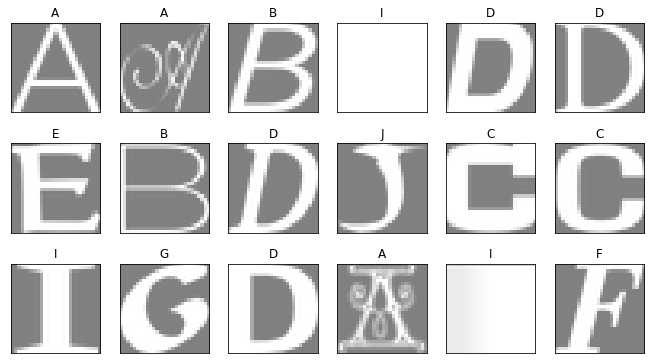

In [9]:
def plot_gallery(images, labels, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of images"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.title(labels[i])
        plt.imshow(images[i].numpy().reshape((28, 28)), cmap=plt.cm.gray, vmin=-1, vmax=1)
        plt.xticks(())
        plt.yticks(())



# get random images from train dataset
dataiter = iter(train_loader)
images, labels = dataiter.next()

# call a function that plot images to cell output
plot_gallery(images, [classes[labels[j]] for j in range(len(images))], IMG_H, IMG_W)

SO our data is ready. Now it's time to build a network.

In [10]:
hid_size = 100
out_size = n_classes

class TwoLayerNet(nn.Module):
    def __init__(self, h, w, hid_size, out_size):
        super(TwoLayerNet, self).__init__()
        # layers
        self.linear1 = nn.Linear(h*w, hid_size)
        self.linear2 = nn.Linear(hid_size, out_size)

    def forward(self, x):
        
        x = self.linear1(x)
        # activation function
        x = F.relu(x)
        x = self.linear2(x)
        return x
    
two_layer_net = TwoLayerNet(h=IMG_H, w=IMG_W, hid_size=hid_size, out_size=out_size)

As a loss function for our network we'll use cross-entropy:

https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

Define learning rate and optimizer -- SGD (we should be already familiar with it)

In [13]:
learning_rate = 1e-3
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

So, finally, a function that implements training:

While training after each epoch we'll measure not only loss (cross-entropy) on train and val set, ut also accuracy. Why? Just because for a person who look on training it's easier to understand how good network is doing looking on accuracy value rather than on cross-entropy. 

In [14]:
from IPython import display
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def train(train_loader, val_loader, num_epochs=100):
    train_losses = []
    val_losses = []

    train_acc = []
    val_acc = []

    for epoch in tqdm(range(num_epochs)):
        display.clear_output(wait=True)
        
        # 1. forward
        two_layer_net.train(True)
        loss_batch = []
        acc_batch = []
        for x_train, y_train in train_loader:
            x_train = Variable(x_train.view(x_train.shape[0], -1))
            # 1.1 get network predictions
            <Your code here>
            # 1.2 compute accuracy on a batch of predictions and real values
            <Your code here>
            # 1.3 compute loss (cross-entropy)
            <Your code here>
            # 1.4 backward
            <Your code here>
            # 1.5 update
            <Your code here>
            # 1.6 null gradient
            <Your code here>
            # 1.7 store loss and accuracy to loss_batch, acc_batch
            <Your code here>

        train_losses.append(np.mean(loss_batch))
        train_acc.append(np.mean(acc_batch))

        # 2. val
        two_layer_net.train(False)
        loss_batch = []
        acc_batch = []
        for i, (x_val, y_val) in enumerate(val_loader):
            x_val = Variable(x_val.view(x_val.shape[0], -1))
            # 2.1 get network predictions
            <Your code here>
            # 2.2 compute accuracy on a batch of predictions and real values
            <Your code here>
            # 2.3 compute loss (cross-entropy)
            <Your code here>
            # 2.4 store loss and accuracy to loss_batch, acc_batch
            <Your code here>

        val_losses.append(np.mean(loss_batch))
        val_acc.append(np.mean(acc_batch))

        # 3. save model to file if on this epoch the network has updated
        <Your code here>

        # 4. show plot
        <Your code here>

        plt.title("losses")
        axes[0].plot(train_losses, label="train loss")
        axes[0].plot(val_losses, label="val loss")
        plt.legend()

        plt.title("accuracies")
        axes[1].plot(train_acc, label="train accuracy")
        axes[1].plot(val_acc, label="val accuracy")
        plt.legend()

        plt.show() 
        
    print("Final loss: ", val_losses[-1])
    print("Final accuracy: ", val_acc[-1])

SyntaxError: invalid syntax (<ipython-input-14-a675f6920846>, line 22)

No handles with labels found to put in legend.


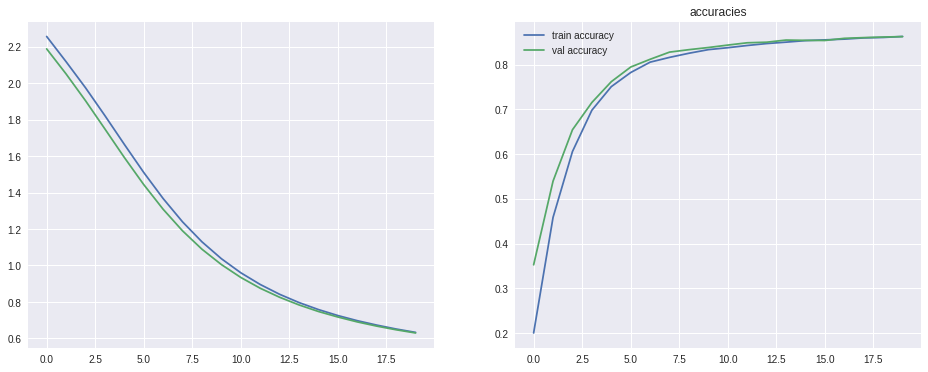

100%|██████████| 20/20 [02:32<00:00,  7.73s/it]

Final loss:  0.6302164
Final accuracy:  0.8625


In [12]:
train(train_loader, val_loader, num_epochs=20)

Let's now remember that SGD is not the only one optimizer exists. There are mamy more -- for example RMSprop, Adam, Adadelta, Adagrad...

Nowadays the best one (talking about convergence speed) is believed to be Adam. So let's try to use Adam instead of SGD in our case:

In [0]:
two_layer_net = TwoLayerNet(h=IMG_H, w=IMG_W, hid_size=hid_size, out_size=out_size)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(two_layer_net.parameters(), lr=learning_rate)

No handles with labels found to put in legend.


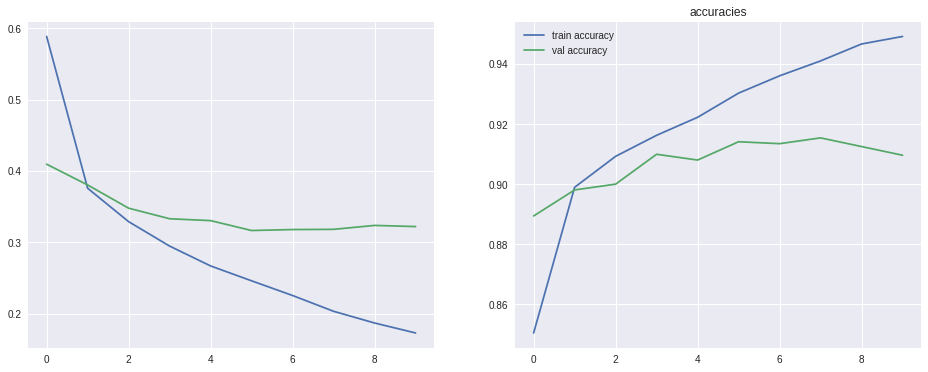

100%|██████████| 10/10 [01:18<00:00,  7.90s/it]

Final loss:  0.3220149
Final accuracy:  0.9096153846153846


In [14]:
train(train_loader, val_loader, num_epochs=10)

Hmm, we can see a strong overfitting. How to deal with that? For example, we can reduce learning rate, then the weights will be updated more "accurately", and the training will be more stable. Let's try!

In [0]:
two_layer_net = TwoLayerNet(h=IMG_H, w=IMG_W, hid_size=hid_size, out_size=out_size)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate=1e-4
optimizer = torch.optim.Adam(two_layer_net.parameters(), lr=learning_rate)

No handles with labels found to put in legend.


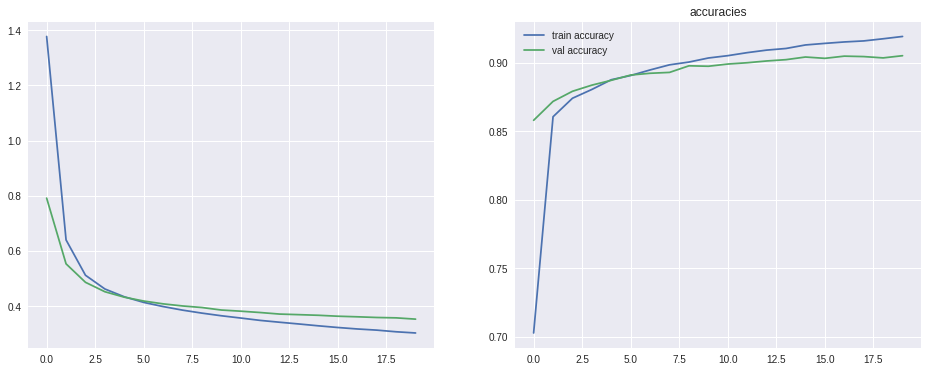

100%|██████████| 20/20 [02:36<00:00,  7.77s/it]

Final loss:  0.3521368
Final accuracy:  0.9051282051282051


In [16]:
train(train_loader, val_loader, num_epochs=20)

So as we see, still taking 20 epochs, Adam managed to train our net 5% accuracy better, though we even hadn't tried to fit hyperparameters. However, we still se a slight overfitting.

---

### Dropout

As we learned from the lecture, dropout is a great technique to fight overfitting. So let's try to apply this on our example =)

In [0]:
hid_size = 100
out_size = n_classes

class TwoLayerNetDropout(nn.Module):
    def __init__(self, h, w, hid_size, out_size):
        super(TwoLayerNetDropout, self).__init__()
        
        # layers
        self.linear1 = nn.Linear(h*w, hid_size)
        self.dropout1 = <Your code here>
        
        self.linear2 = nn.Linear(hid_size, hid_size)
        self.dropout2 = <Your code here>

    def forward(self, x):
        
        # don't forget activations
        <Your code here>
        return x

In [0]:
two_layer_net = TwoLayerNetDropout(h=IMG_H, w=IMG_W, hid_size=hid_size, out_size=out_size)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate=1e-3
optimizer = torch.optim.Adam(two_layer_net.parameters(), lr=learning_rate)

In [1]:
train(train_loader, val_loader, num_epochs=20)

### Batch Normalization (BatchNorm) 

And also let's play with batch normalization. How will network perfomance change and why?

In [0]:
hid_size = 100
out_size = n_classes

class TwoLayerNetBN(nn.Module):
    def __init__(self, h, w, hid_size, out_size):
        super(TwoLayerNet_BN, self).__init__()
        # объявляем слои для нашей сети
        self.linear1 = nn.Linear(h*w, hid_size)
        self.dropout1 = <Your code here>
        self.batch_norm1 = nn.BatchNorm1d(hid_size)
        
        self.linear2 = nn.Linear(hid_size, hid_size)
        self.dropout2 = <Your code here>
        self.batch_norm2 = nn.BatchNorm1d(hid_size)
       
        self.linear3 = nn.Linear(hid_size, out_size)

    def forward(self, x):
        
        # don't forget activations
        <Your code here>
        return x

In [0]:
two_layer_net = TwoLayerNetBN(h=IMG_H, w=IMG_W, hid_size=hid_size, out_size=out_size)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate=5e-4
optimizer = torch.optim.Adam(two_layer_net.parameters(), lr=learning_rate)

In [0]:
train(train_loader, val_loader, num_epochs=20)